# Thalamic segmentation localization
### 2016_05_30

In [4]:
import pandas as pd
import os
import re
import numpy
import nibabel
import argparse
import textwrap
import time
import numpy as np
import pp
import nipype.interfaces.fsl as fsl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pp
from __future__ import division
import glob
from copy import copy
import operator
import pickle

In [5]:
def regCheck(img, z_axis):
    #read nifti
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
    
    data = nibabel.load(img).get_data()
    c1 = numpy.concatenate([data[:,:,x] for x in range(z_axis-2,z_axis)])
    c2 = numpy.concatenate([data[:,:,x] for x in range(z_axis,z_axis+2)])
    data_to_show = numpy.flipud(numpy.concatenate([c1,c2],axis=1).T)
    ax1.imshow(data_to_show, cmap=plt.cm.gray)#, alpha=.8)   
    ax1.set_title(os.path.basename(img))
    
    ref_data = nibabel.load('/usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz').get_data()
    ref_c1 = numpy.concatenate([ref_data[:,:,x] for x in range(z_axis-2,z_axis)])
    ref_c2 = numpy.concatenate([ref_data[:,:,x] for x in range(z_axis,z_axis+2)])
    ref_data_to_show = numpy.flipud(numpy.concatenate([ref_c1,ref_c2],axis=1).T)
    ax2.imshow(ref_data_to_show, cmap=plt.cm.gray)#, alpha=.2)
    ax2.set_title('MNI 1mm brain')

    ax3.imshow(data_to_show, cmap=plt.cm.gray, alpha=.8)
    ax3.imshow(ref_data_to_show, alpha=.2)
    ax3.set_title('MNI overlay')
    plt.show()

In [6]:
def show_nifti(img, sliceNum):
    fig, ax = plt.subplots(ncols=1, figsize=(5,5))
    data = nibabel.load(img).get_data()
    c1 = numpy.concatenate([data[:,:,x] for x in range(sliceNum-2, sliceNum)])
    c2 = numpy.concatenate([data[:,:,x] for x in range(sliceNum, sliceNum+2)])
    data_to_show = numpy.flipud(numpy.concatenate([c1,c2], axis=1).T)
#     data_to_show = numpy.flipud(data[:,:,140].T)
    ax.imshow(data_to_show, cmap=plt.cm.gray)
    ax.set_title('Orig image')
    plt.show()

In [7]:
cortices = ["LPFC","LTC","MPFC","MTC","OFC","PC","SMC",'OCC']

In [8]:
dataLoc = os.getcwd()
subjects = [x for x in os.listdir(dataLoc) if x.startswith('N') or x.startswith('F')]

## Registration of the thalamic segments to MNI

> T1 ROI to MNI example

In [9]:
def FNIRT_T1_to_MNI(t1, mni, roi, outdir):
#     show_nifti(t1, 120)
    
    flirt_out_img = os.path.join(outdir, 'freesurfer_2_mni_flirt.nii.gz')
    flirt_out_mat = os.path.join(outdir, 'freesurfer_2_mni_flirt.mat')
    # FLIRT first
    
    if not os.path.isfile(flirt_out_mat):
        flirt = fsl.FLIRT(in_file = t1,
                         reference = mni,
                         out_matrix_file =  flirt_out_mat,
                         out_file = flirt_out_img
                         )
        print flirt.cmdline
        #flirt.run()
#     regCheck(flirt_out_img, 70)
    
    fnirt_out_img = os.path.join(outdir, 'freesurfer_2_mni_fnirt.nii.gz')
    fnirt_out_coeff = os.path.join(outdir, 'freesurfer_2_mni_fnirt_coeff.nii.gz')
    if not os.path.isfile(fnirt_out_coeff):
        fnirt = fsl.FNIRT(in_file = t1,
                          ref_file = mni,
                          affine_file = flirt_out_mat,
                          warped_file = fnirt_out_img,
                          fieldcoeff_file = fnirt_out_coeff,
                          refmask_file = '/usr/local/fsl/data/standard/MNI152_T1_1mm_brain_mask_dil.nii.gz'
                         )
        print fnirt.cmdline
        #fnirt.run()
#     regCheck(fnirt_out_img, 70)
    
    fnirt_roi = os.path.join(outdir, os.path.basename(roi).split('.')[0]+'_mni_fnirt.nii.gz')
    if not os.path.isfile(fnirt_roi):
        applywarp = fsl.ApplyWarp(in_file = roi,
                                 ref_file = mni,
                                 out_file = fnirt_roi,
                                 field_file = fnirt_out_coeff,
                                 interp = 'nn'
                                 )
        print applywarp.cmdline
        applywarp.run()
        
    regCheck(fnirt_roi, 70)
        

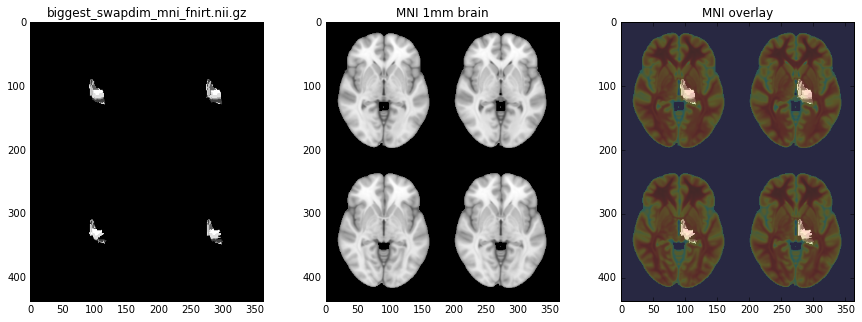

In [7]:
FNIRT_T1_to_MNI('/Volumes/CCNC_3T/KangIk/2014_05_DKI_project/phd/newDTI/NOR24_YJA/freesurfer/mri/brain.nii.gz',
               '/usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz',
                '/Volumes/CCNC_3T/KangIk/2014_05_DKI_project/phd/newDTI/NOR24_YJA/segmentation/left/biggest_swapdim.nii.gz',
               '/Volumes/CCNC_3T/KangIk/2014_05_DKI_project/phd/newDTI/NOR24_YJA/registration')

> for all subjects

In [ ]:
for x in subjects:
    print x
    t1 = os.path.join(dataLoc, x, 'freesurfer/mri/brain.nii.gz')
    mni = '/usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
    outDir = os.path.join(dataLoc, x, 'registration')
    
    imgList = [x for x in glob.glob(os.path.join(dataLoc, x, 'segmentation','*','[bs]*')) if 'swapdim' not in x]
    #imgList = [x for x in glob.glob(os.path.join(dataLoc, x, 'segmentation','*','90*','90*')) if 'swapdim' not in x]
    for img in imgList:
        swapdimLoc = re.sub('.nii.gz','_swapdim.nii.gz', img)
     
        if not os.path.isfile(swapdimLoc):
            print swapdimLoc
            command = "fslswapdim {img} RL PA IS {swapdimImg}".format(img = img,
                                                                      swapdimImg = swapdimLoc)
            os.popen(command).read()
        if not os.path.isfile(os.path.join(outDir, os.path.basename(swapdimLoc).split('.')[0]+'_mni_fnirt.nii.gz')):
            FNIRT_T1_to_MNI(t1, mni, swapdimLoc, outDir)
            print swapdimLoc
            

# Reading the registered thalamus to compare with the MNI thalamus

> MNI thalamus

/ccnc_bin/venv/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


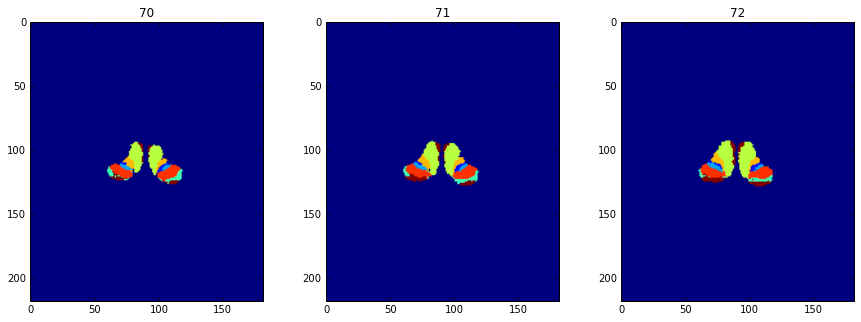

In [10]:
mniThal = '/usr/local/fsl/data/atlases/Thalamus/Thalamus-maxprob-thr25-1mm.nii.gz'

data = nibabel.load(mniThal).get_data()
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,5))

num = 70
for i, ax in zip(range(num,num+3), [ax1,ax2,ax3]):
    ax.imshow(np.flipud(data[:,:,i].T))
    ax.set_title(i)
fig.show()

> Range of numbers (number of thalamic nuclei ROIs)

In [11]:
np.unique(data)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

> Overlay one example subject data

/ccnc_bin/venv/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


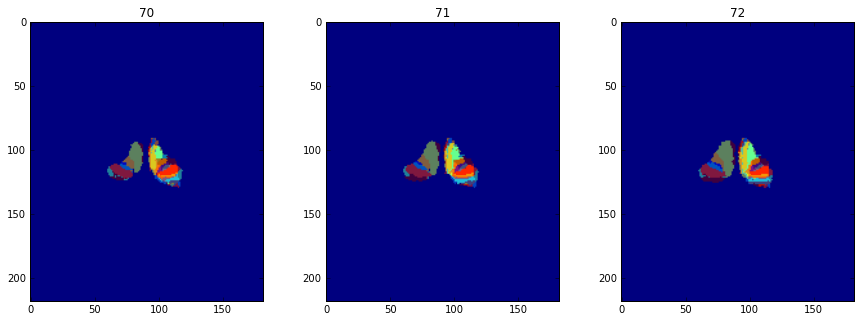

In [9]:
data = nibabel.load(mniThal).get_data()
data_subj = nibabel.load('/Volumes/CCNC_3T/KangIk/2014_05_DKI_project/phd/newDTI/NOR24_YJA/registration/biggest_swapdim_mni_fnirt.nii.gz').get_data()
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,5))

num = 70
for i, ax in zip(range(num,num+3), [ax1,ax2,ax3]):
    ax.imshow(np.flipud(data[:,:,i].T))
    ax.imshow(np.flipud(data_subj[:,:,i].T),alpha = 0.5)
    ax.set_title(i)
fig.show()

### Plan

1. Calculate area overlap in MD in each subject.
2. Estimate the ratio between the overlap volume / whole MD volume in each sujbect.
3. Average them

> MD mask in MNI Behrens et al., 2007

```
<label index="0" x="74" y="104" z="72">Primary motor</label>
<label index="1" x="106" y="101" z="73">Sensory</label>
<label index="2" x="103" y="95" z="76">Occipital</label>
<label index="3" x="99" y="114" z="77">Pre-frontal</label>
<label index="4" x="71" y="109" z="81">Pre-motor</label>
<label index="5" x="110" y="99" z="75">Posterior parietal</label>
<label index="6" x="101" y="97" z="83">Temporal</label>
```

In [12]:
np.unique(data)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

```
targets.txt
/Volumes/CCNC_M2_2/kcho/phd/NOR24_YJA/ROI/lh_LPFC.nii.gz
/Volumes/CCNC_M2_2/kcho/phd/NOR24_YJA/ROI/lh_LTC.nii.gz
/Volumes/CCNC_M2_2/kcho/phd/NOR24_YJA/ROI/lh_MPFC.nii.gz
/Volumes/CCNC_M2_2/kcho/phd/NOR24_YJA/ROI/lh_MTC.nii.gz
/Volumes/CCNC_M2_2/kcho/phd/NOR24_YJA/ROI/lh_OCC.nii.gz
/Volumes/CCNC_M2_2/kcho/phd/NOR24_YJA/ROI/lh_OFC.nii.gz
/Volumes/CCNC_M2_2/kcho/phd/NOR24_YJA/ROI/lh_PC.nii.gz
/Volumes/CCNC_M2_2/kcho/phd/NOR24_YJA/ROI/lh_SMC.nii.gz
```

In [13]:
np.unique(data_subj)

NameError: name 'data_subj' is not defined

> Overlap between each subject's thalamus nuclei with the MNI template thalamic nuclei

In [14]:
def get_overlap_raw(mni_thal_bool_array, subj_bool_array):
    mdMask_overlap = mni_thal_bool_array & subj_bool_array
    return (np.sum(mdMask_overlap) / np.sum(subj_bool_array)) * 100

In [15]:
mniThal = '/usr/local/fsl/data/atlases/Thalamus/Thalamus-maxprob-thr25-1mm.nii.gz'
mniThal_data = nibabel.load(mniThal).get_data()

talairach = '/usr/local/fsl/data/atlases/Talairach/Talairach-labels-1mm.nii.gz'
talairach_data = nibabel.load(talairach).get_data()

# Averaging nuclei in subjects

> for OFC and LTC (both sides)
- Thresholded

In [16]:
allData = {}

if not os.path.isfile('allData_dict.pickle'):
    for side in 'lh','rh':
        for cortex in 'OFC', 'LTC':
            for subject in subjects:
                imgList = glob.glob(os.path.join(dataLoc, subject, 'registration/90*{side}*swapdim_mni_fnirt.nii.gz'.format(side=side)))
                ofcList = [x for x in imgList if cortex in x]
                ofcLoc = ''.join(ofcList)

                data = nibabel.load(ofcLoc).get_data()

                try:
                    total += data
                except:
                    total = np.zeros_like(data)
                    total += data
            allData[side+'_'+cortex] = total
            total = np.zeros_like(data)

    pickle.dump(allData, open( 'allData_dict.pickle', "wb" ))
else:
    allData = pickle.load(open('allData_dict.pickle', 'rb'))

> for OFC and LTC (both sides)
> - Not thresholded

In [17]:
nothr_allData = {}

if not os.path.isfile('nothr_allData_dict.pickle'):
    for side in 'lh','rh':
        for cortex in 'OFC', 'LTC':
            for subject in subjects:
                imgList = glob.glob(os.path.join(dataLoc, 
                                                 subject, 
                                                 'registration/seeds*{side}*swapdim_mni_fnirt.nii.gz'.format(side=side)))
                ofcList = [x for x in imgList if cortex in x]
                ofcLoc = ''.join(ofcList)

                try:
                    data = nibabel.load(ofcLoc).get_data()
                except:
                    print side, cortex, subject, ofcLoc

                try:
                    total += data
                except:
                    total = np.zeros_like(data)
                    total += data
            nothr_allData[side+'_'+cortex] = total
            total = np.zeros_like(data)

    pickle.dump(nothr_allData, open( 'nothr_allData_dict.pickle', "wb" ))
else:
    nothr_allData = pickle.load(open('nothr_allData_dict.pickle','rb'))

In [18]:
mni = '/usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
mni_data = nibabel.load(mni).get_data()

In [19]:
def draw_brain_both_side(allData, cortex):
    my_cmap = copy(matplotlib.cm.get_cmap('jet')) # make a copy so we don't mess up system copy
    my_cmap.set_under('r', alpha=0) # make locations over vmax translucent red
    slices = range(66,88,4)

    for num, i in enumerate(slices):
        fig, axes = plt.subplots(nrows=1, figsize=(10,10), dpi=300)
        axes.imshow(np.flipud(mni_data[:,:,i].T), cmap=plt.cm.gray)
        for side in 'lh', 'rh':
            side_cortex = side+'_'+cortex
            total_zero_nan = allData[side_cortex]
            total_zero_nan[total_zero_nan==0] == np.nan
            s = axes.imshow(np.flipud(total_zero_nan[:,:,i].T), clim=(0, 60000), cmap=my_cmap, vmin=1, alpha=0.4)
            axes.set_title(i)
        cbar = plt.colorbar(s, ax=axes)
    #    plt.colorbar()
        plt.savefig('/Users/admin/Desktop/{side_cortex}_{i}.png'.format(side_cortex=side_cortex,
                                                                   i=i))

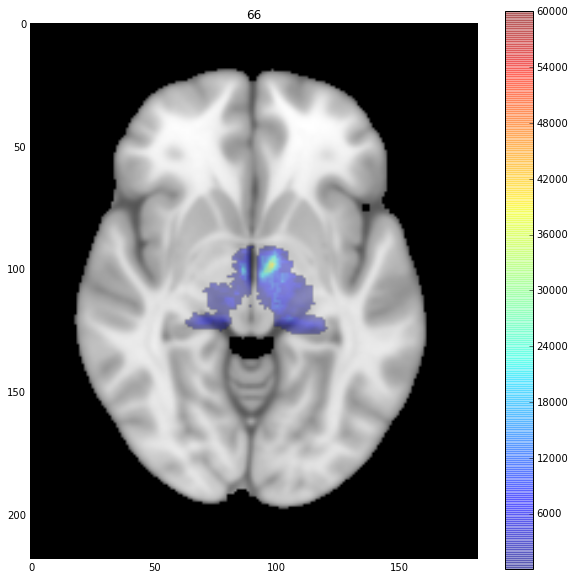

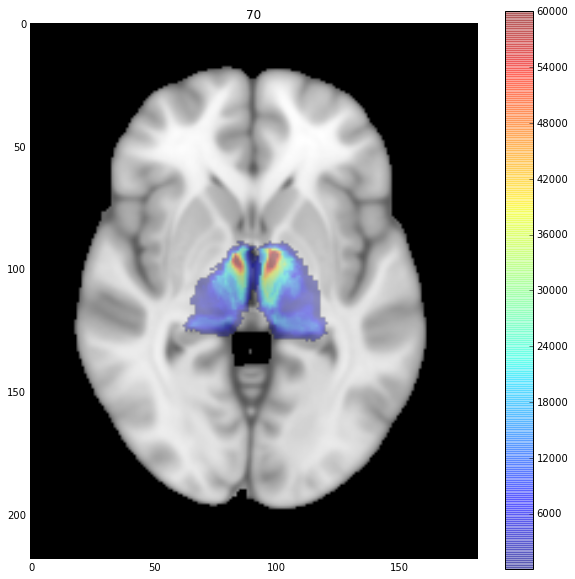

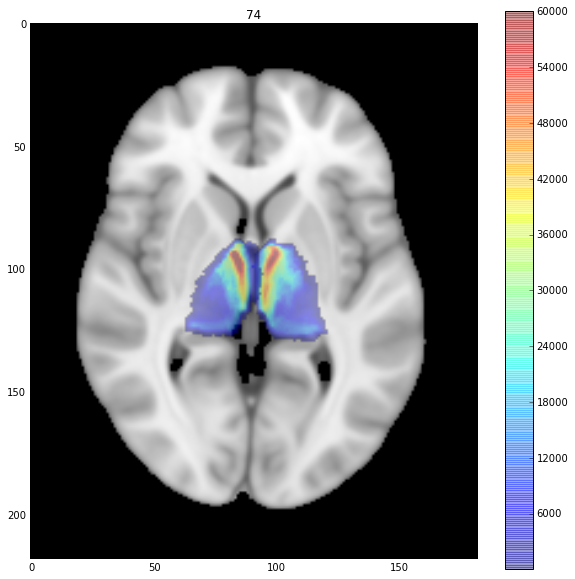

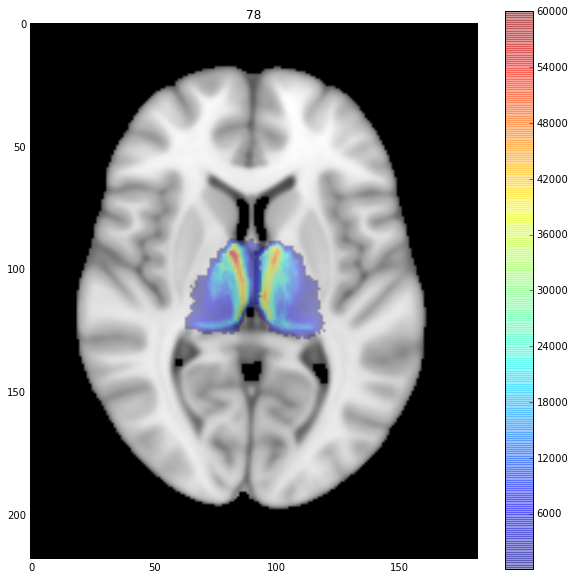

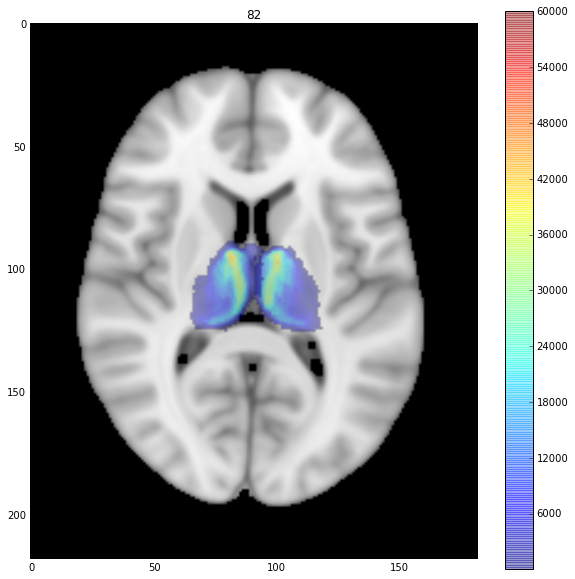

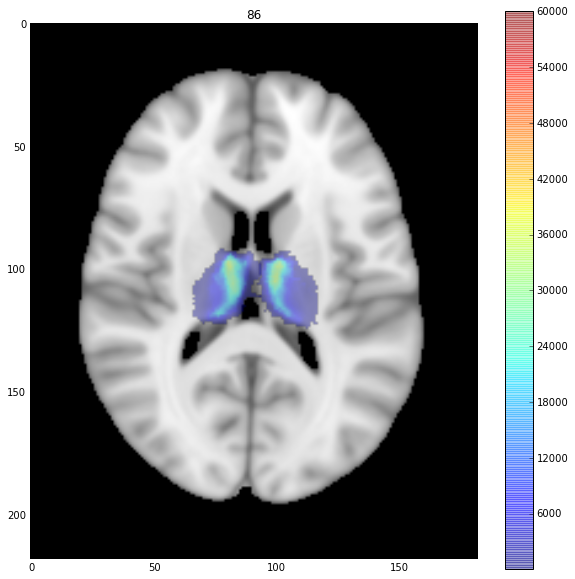

In [514]:
draw_brain_both_side(nothr_allData, 'OFC')

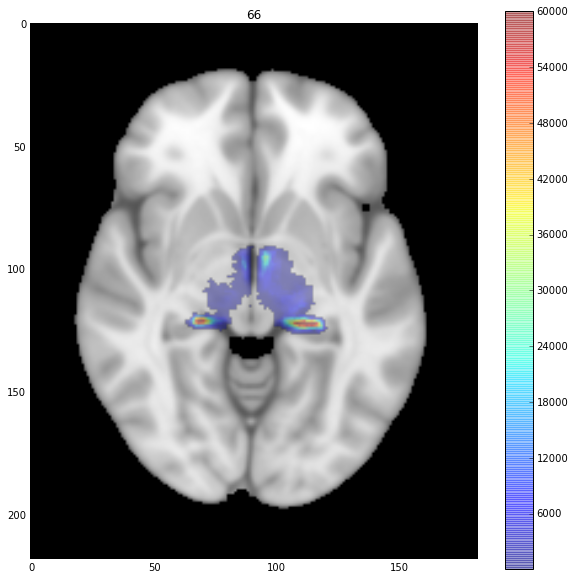

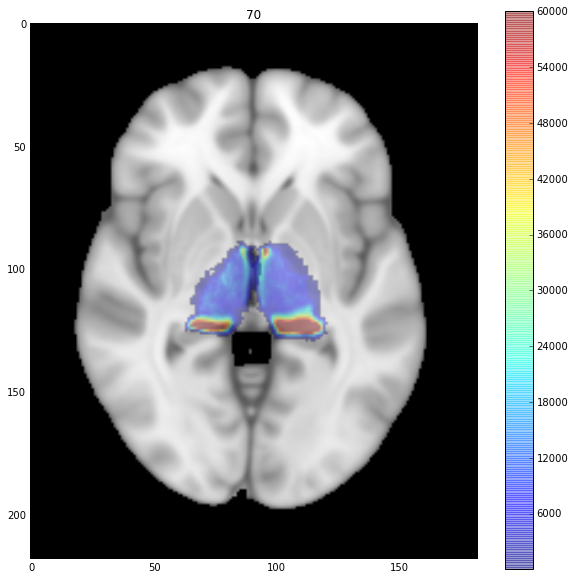

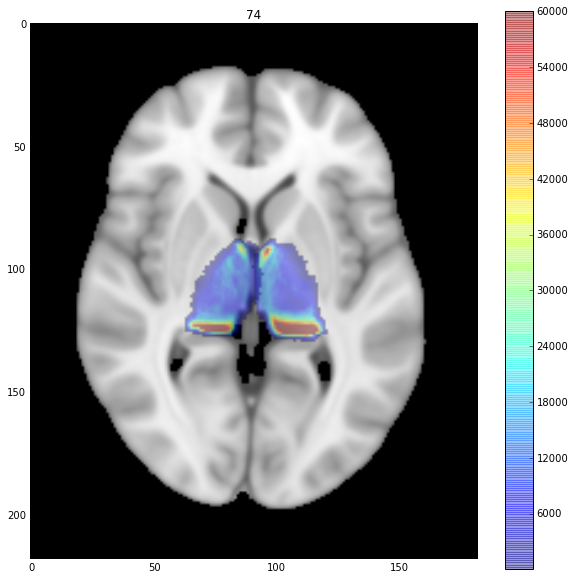

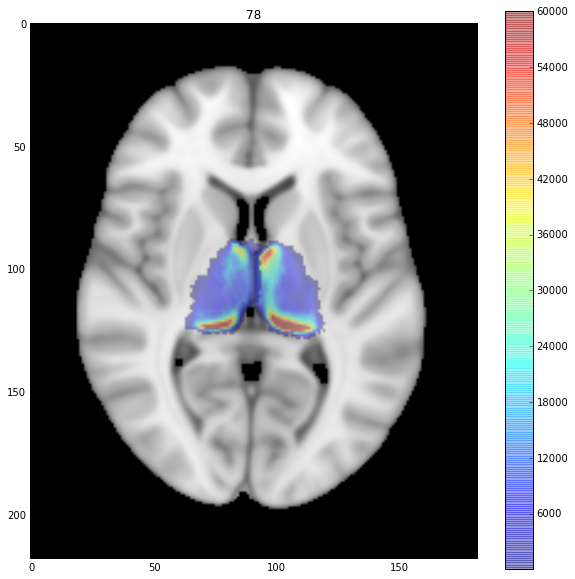

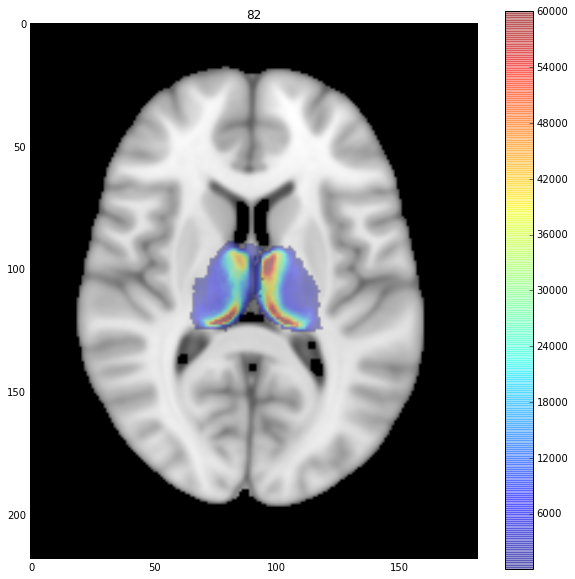

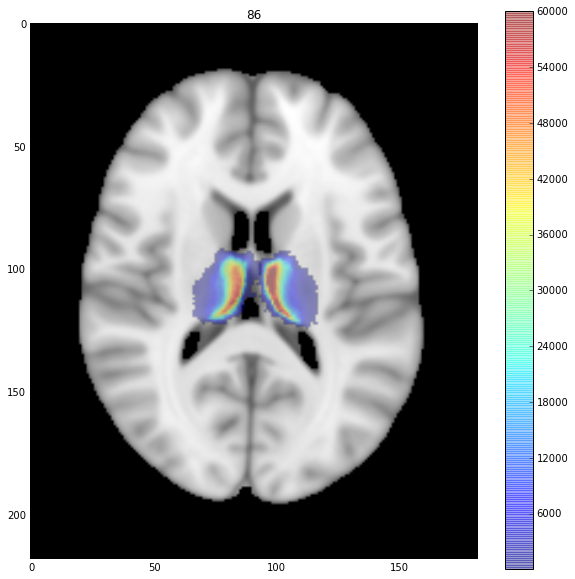

In [515]:
draw_brain_both_side(nothr_allData, 'LTC')

(array([ 9489.,  4221.,  2409.,  1376.,   780.,   415.,   178.,   103.,
           50.,    23.]),
 array([  1.00000000e+00,   7.65660000e+03,   1.53122000e+04,
          2.29678000e+04,   3.06234000e+04,   3.82790000e+04,
          4.59346000e+04,   5.35902000e+04,   6.12458000e+04,
          6.89014000e+04,   7.65570000e+04]),
 <a list of 10 Patch objects>)

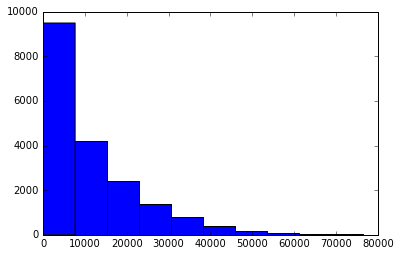

In [20]:
ofc_lh_unthresholded = nothr_allData['lh_OFC']
plt.hist(ofc_lh_unthresholded[ofc_lh_unthresholded != 0].ravel())

# Talairach Thalamus Nuclei

In [21]:
tal_thal_dict = {
    0:'Out of talairach threshold',
    437  :   'Left Brainstem.Midbrain.Thalamus.Gray Matter.Medial Geniculum Body',
    438  :   'Right Brainstem.Midbrain.Thalamus.Gray Matter.Medial Geniculum Body',
    529  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.*',
    531  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.*',
    579  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Posterior Lateral Nucleus',
    580  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Posterior Medial Nucleus',
    581  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Mammillary Body',
    582  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Mammillary Body',
    583  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Posterior Medial Nucleus',
    584  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Posterior Lateral Nucleus',
    622  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar',
    623  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar',
    636  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus',
    637  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus',
    643  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Lateral Nucleus',
    644  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Lateral Nucleus',
#    645  :   'Right Cerebrum.*.Thalamus.Gray Matter.*',
    646  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Anterior Nucleus',
    647  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Anterior Nucleus',
    684  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus',
    686  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus',
    725  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Lateral Posterior Nucleus',
    726  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Lateral Posterior Nucleus',
    787  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Lateral Dorsal Nucleus',
    788  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Lateral Dorsal Nucleus',
    790  :   'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Midline Nucleus',
    791  :   'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Midline Nucleus'}

> Calculate overlap between the Talairach thalamus ROIs

In [22]:
thalamusMaskBoolList = [talairach_data==x for x in tal_thal_dict]
overlap = reduce(lambda x,y: x*y, thalamusMaskBoolList) # multiply every item in a list
print np.sum(overlap)

0


> Show the Talairach thalamus ROIs

In [23]:
thal_only_talairach = [x*1 for x in thalamusMaskBoolList]
mask = reduce(lambda x,y: x+y, thalamusMaskBoolList)
mask[mask > 0] =1
talairach_thalamus = talairach_data * mask

> Make colour maps

In [24]:
colourmap_thalamus={'Left Brainstem.Midbrain.Thalamus.Gray Matter.Medial Geniculum Body': 'gold',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.*': 'gray',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus': 'mediumpurple',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Lateral Dorsal Nucleus': 'lightcoral',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Lateral Posterior Nucleus': 'lightgreen',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Mammillary Body': 'skyblue',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus': 'r',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Midline Nucleus': 'lemonchiffon',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar': 'limegreen',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Anterior Nucleus': 'lightcyan',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Lateral Nucleus': 'royalblue',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Posterior Lateral Nucleus': 'lavender',
 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Posterior Medial Nucleus': 'mistyrose',
 'Out of talairach threshold': 'lightgray',
 'Right Brainstem.Midbrain.Thalamus.Gray Matter.Medial Geniculum Body': 'gold',
 #'Right Cerebrum.*.Thalamus.Gray Matter.*': 'gray',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.*': 'gray',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus': 'mediumpurple',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Lateral Dorsal Nucleus': 'lightcoral',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Lateral Posterior Nucleus': 'lightgreen',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Mammillary Body': 'skyblue',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus': 'r',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Midline Nucleus': 'lemonchiffon',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar': 'limegreen',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Anterior Nucleus': 'lightcyan',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Lateral Nucleus': 'royalblue',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Posterior Lateral Nucleus': 'lavender',
 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Posterior Medial Nucleus': 'mistyrose',
                   'other':'gray'}


> Pie chart

> Volume classification

data shape (182, 218, 182)
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.* 529
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar 622
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus 636
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Lateral Nucleus 643
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Anterior Nucleus 646
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus 686
overlap_volumes_dict {'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus': 18.572927597061909, 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Lateral Nucleus': 11.122770199370409, 'other': 1.7838405036726126, 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.*': 27.806925498426022, 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Anterior Nucleus': 14.060860440713535}
overlap_connectivity_sum_dict {'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus': 16.700023412704468, 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Lateral N

/ccnc_bin/venv/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/ccnc_bin/venv/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


 {'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.*': 31.71007927519819, 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus': 14.949037372593432, 'other': 1.5855039637599093, 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus': 31.370328425821064}
overlap_connectivity_sum_dict {'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.*': 33.774948120117188, 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus': 15.897046029567719, 'other': 1.8672164529561996, 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus': 29.396367073059082}
data shape (182, 218, 182)
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.* 529
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar 622
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus 636
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Anterior Nucleus 646
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus 686
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Midline Nucleus 790
ov

/ccnc_bin/venv/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/ccnc_bin/venv/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


 {'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.*': 14.609286523216308, 'other': 1.245753114382786, 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar': 21.177802944507363}
overlap_connectivity_sum_dict {'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.*': 15.235112607479095, 'other': 0.98425567848607898, 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar': 21.581882238388062}


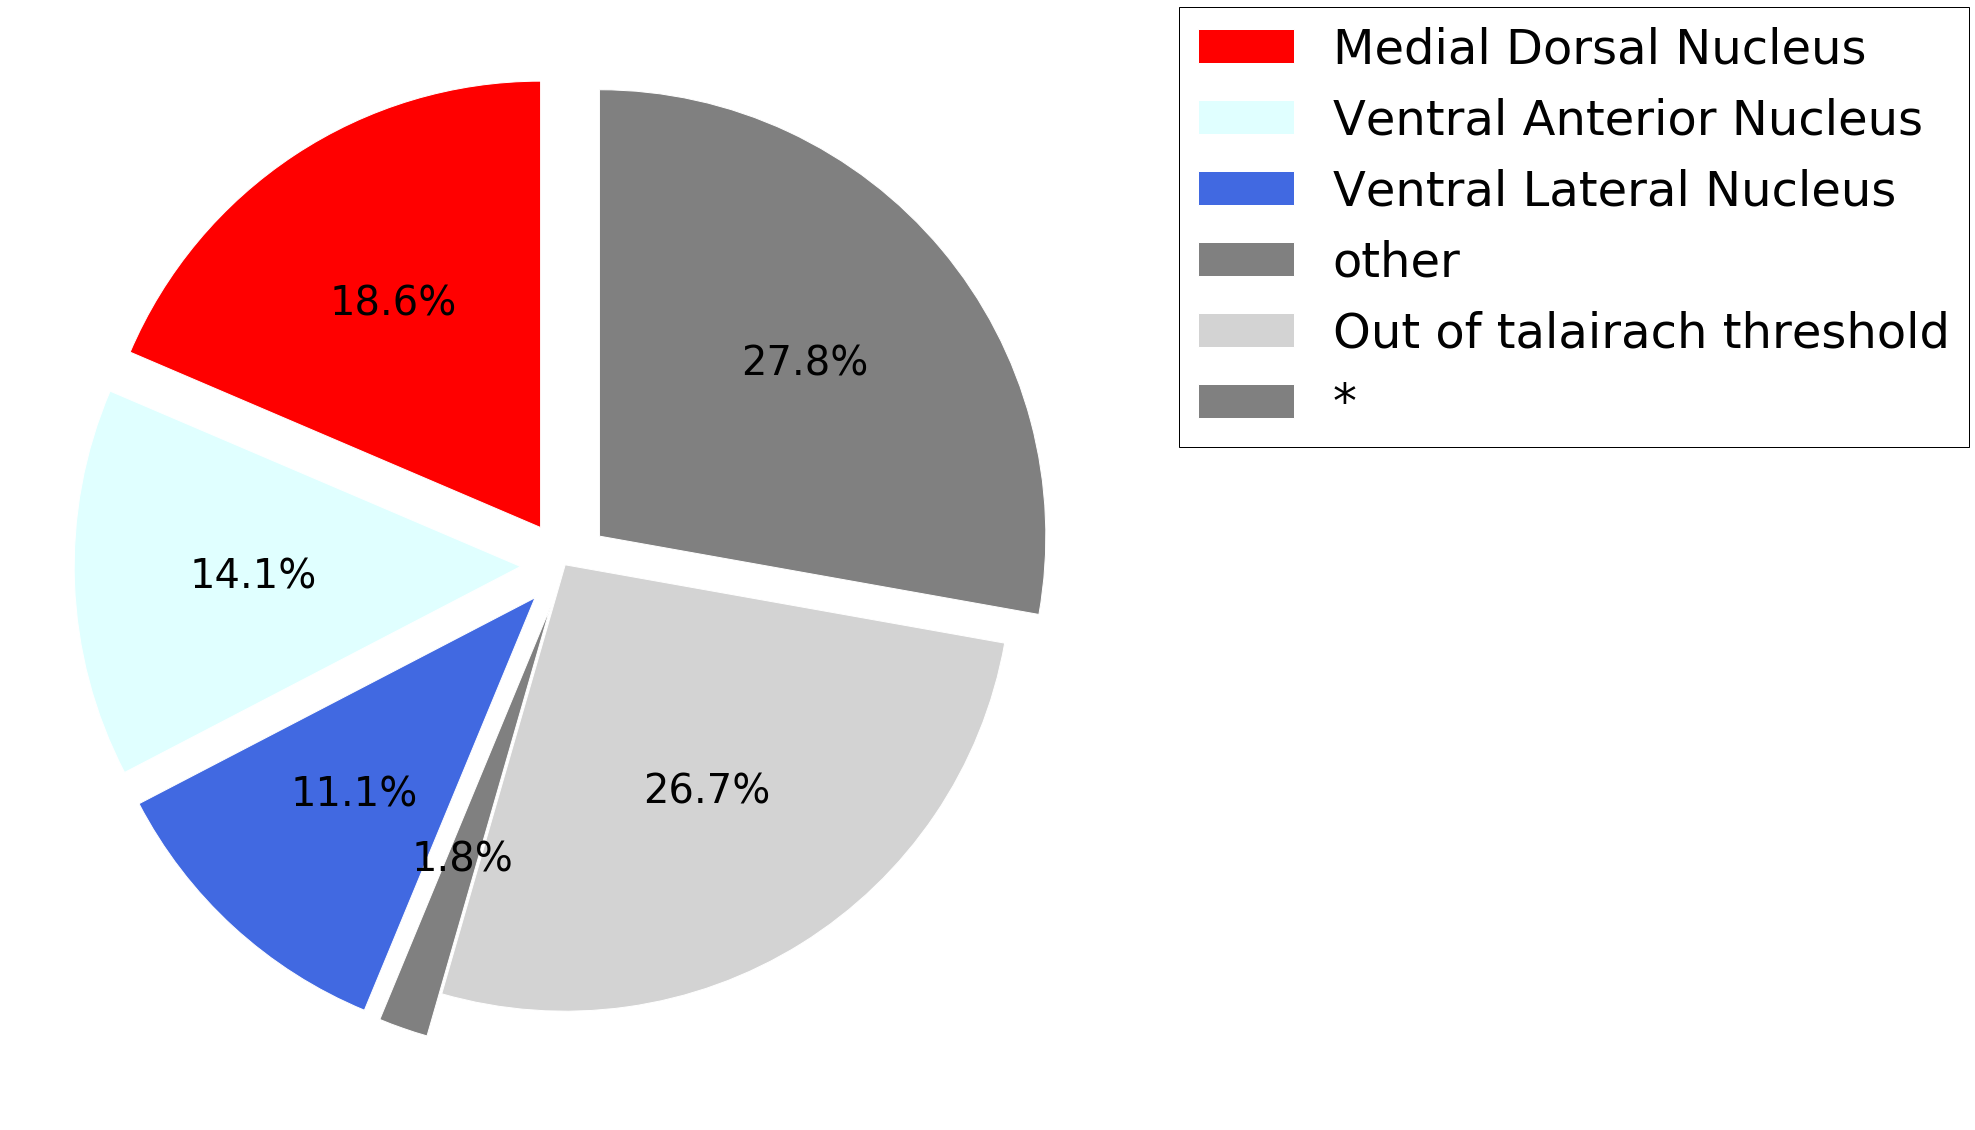

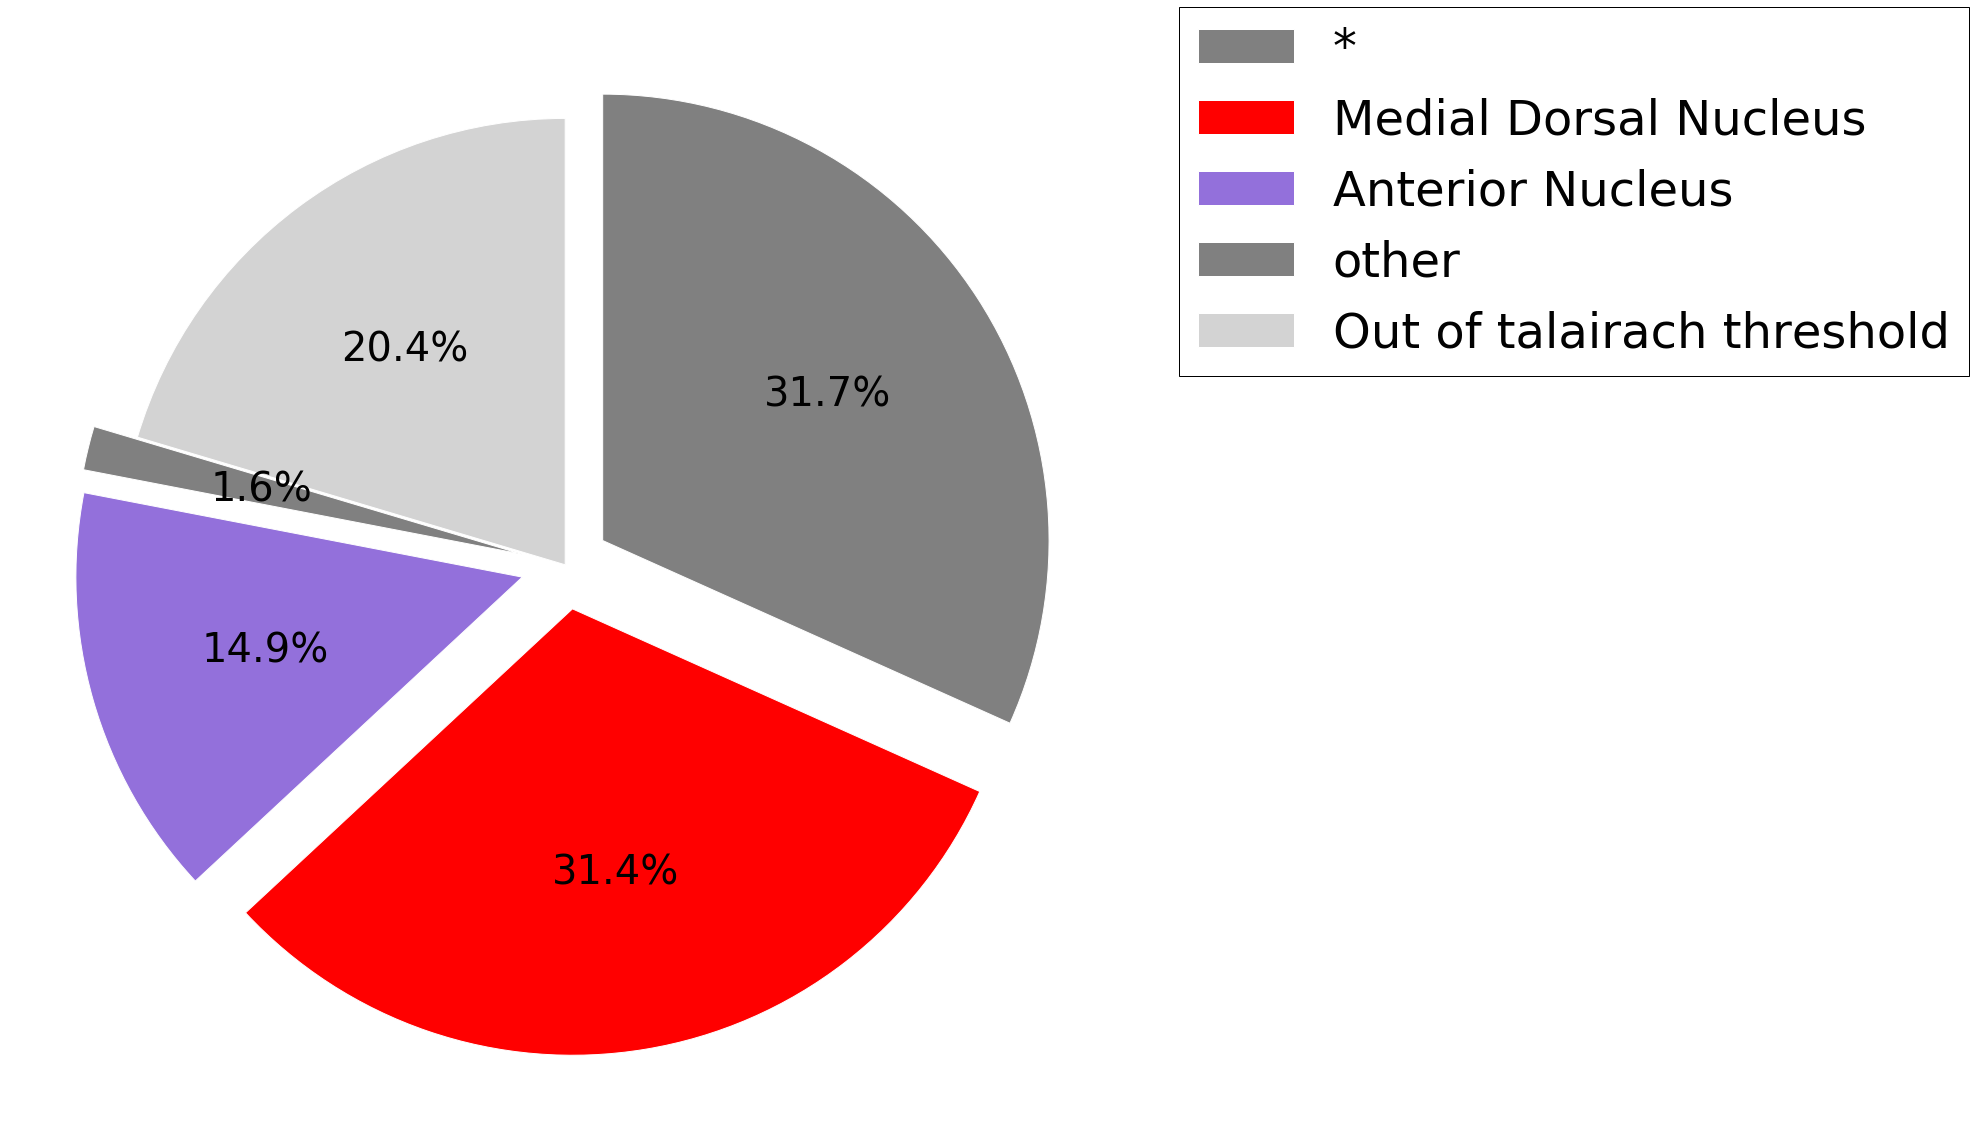

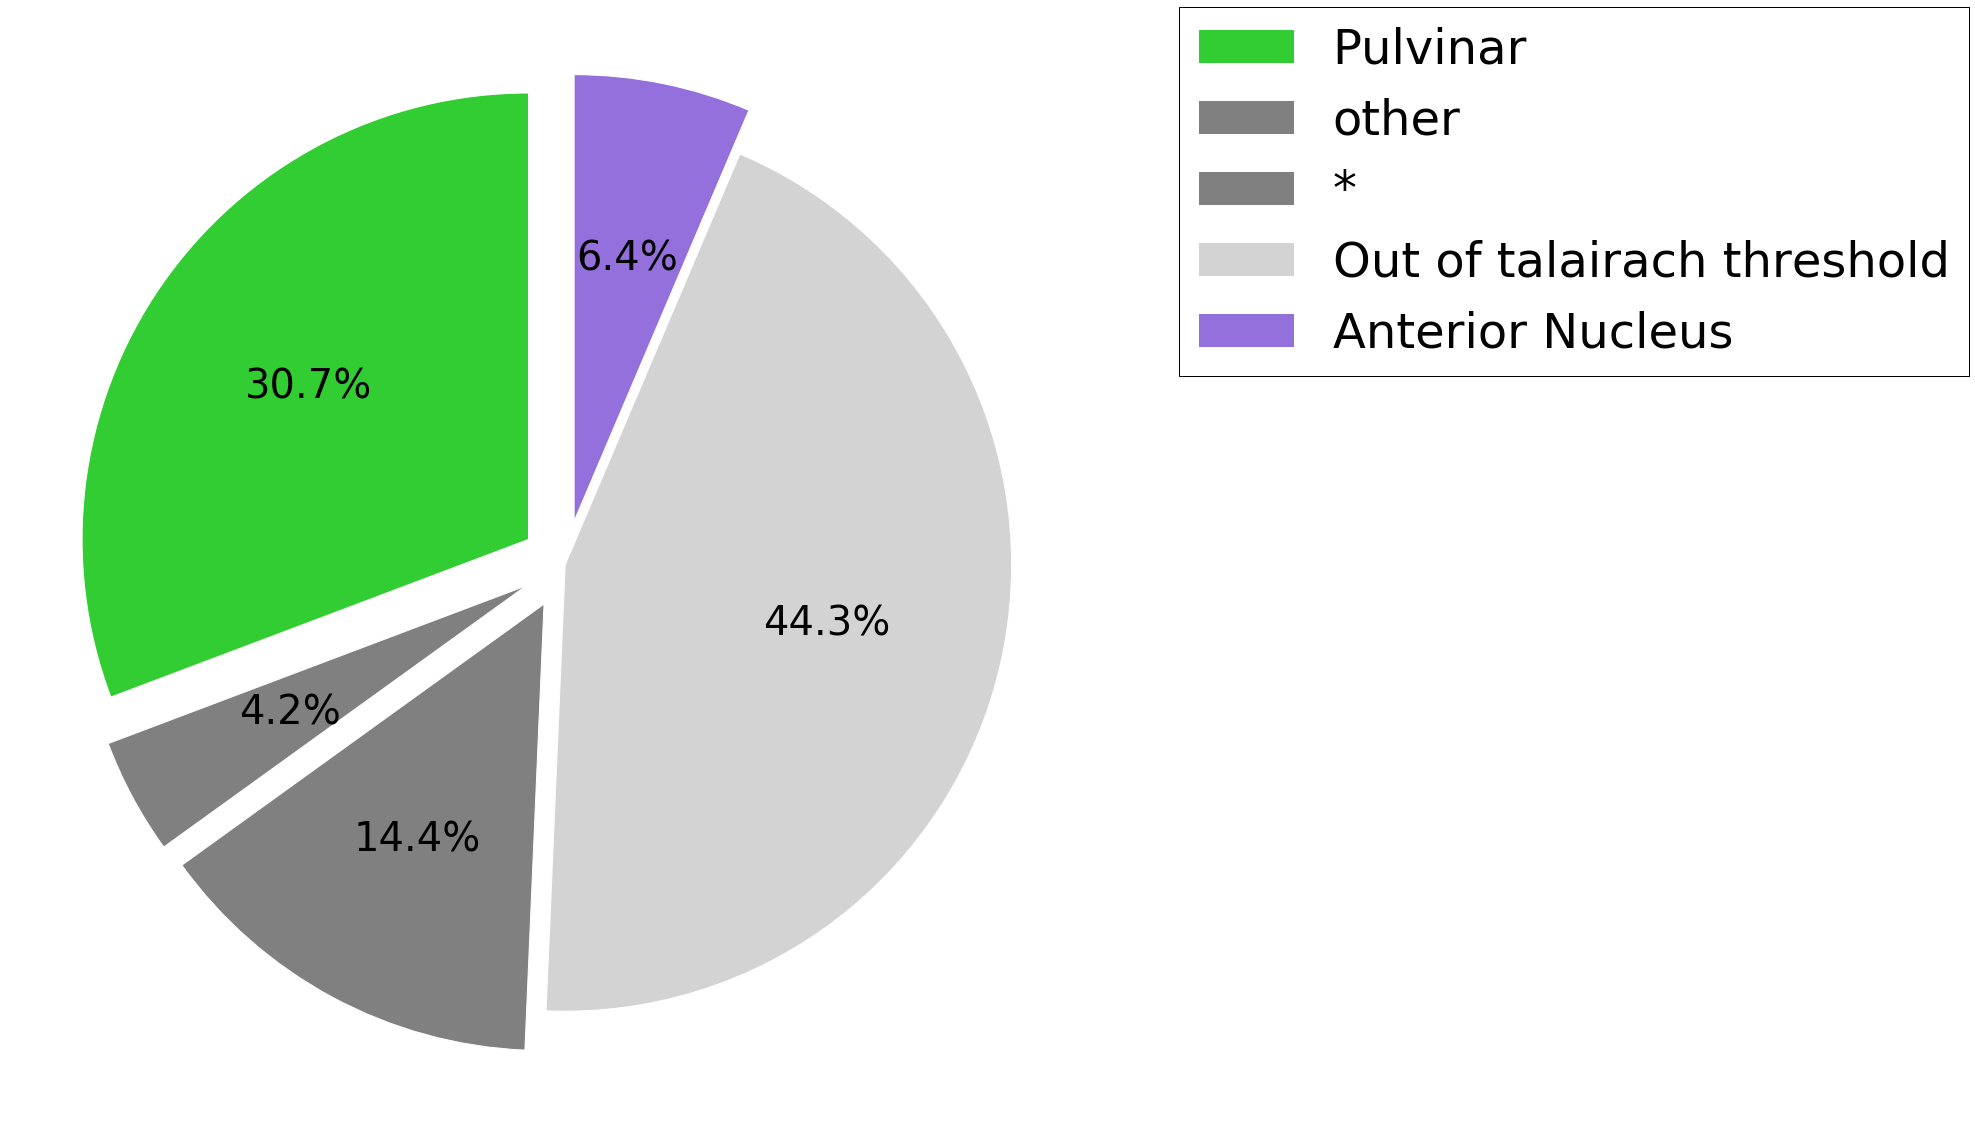

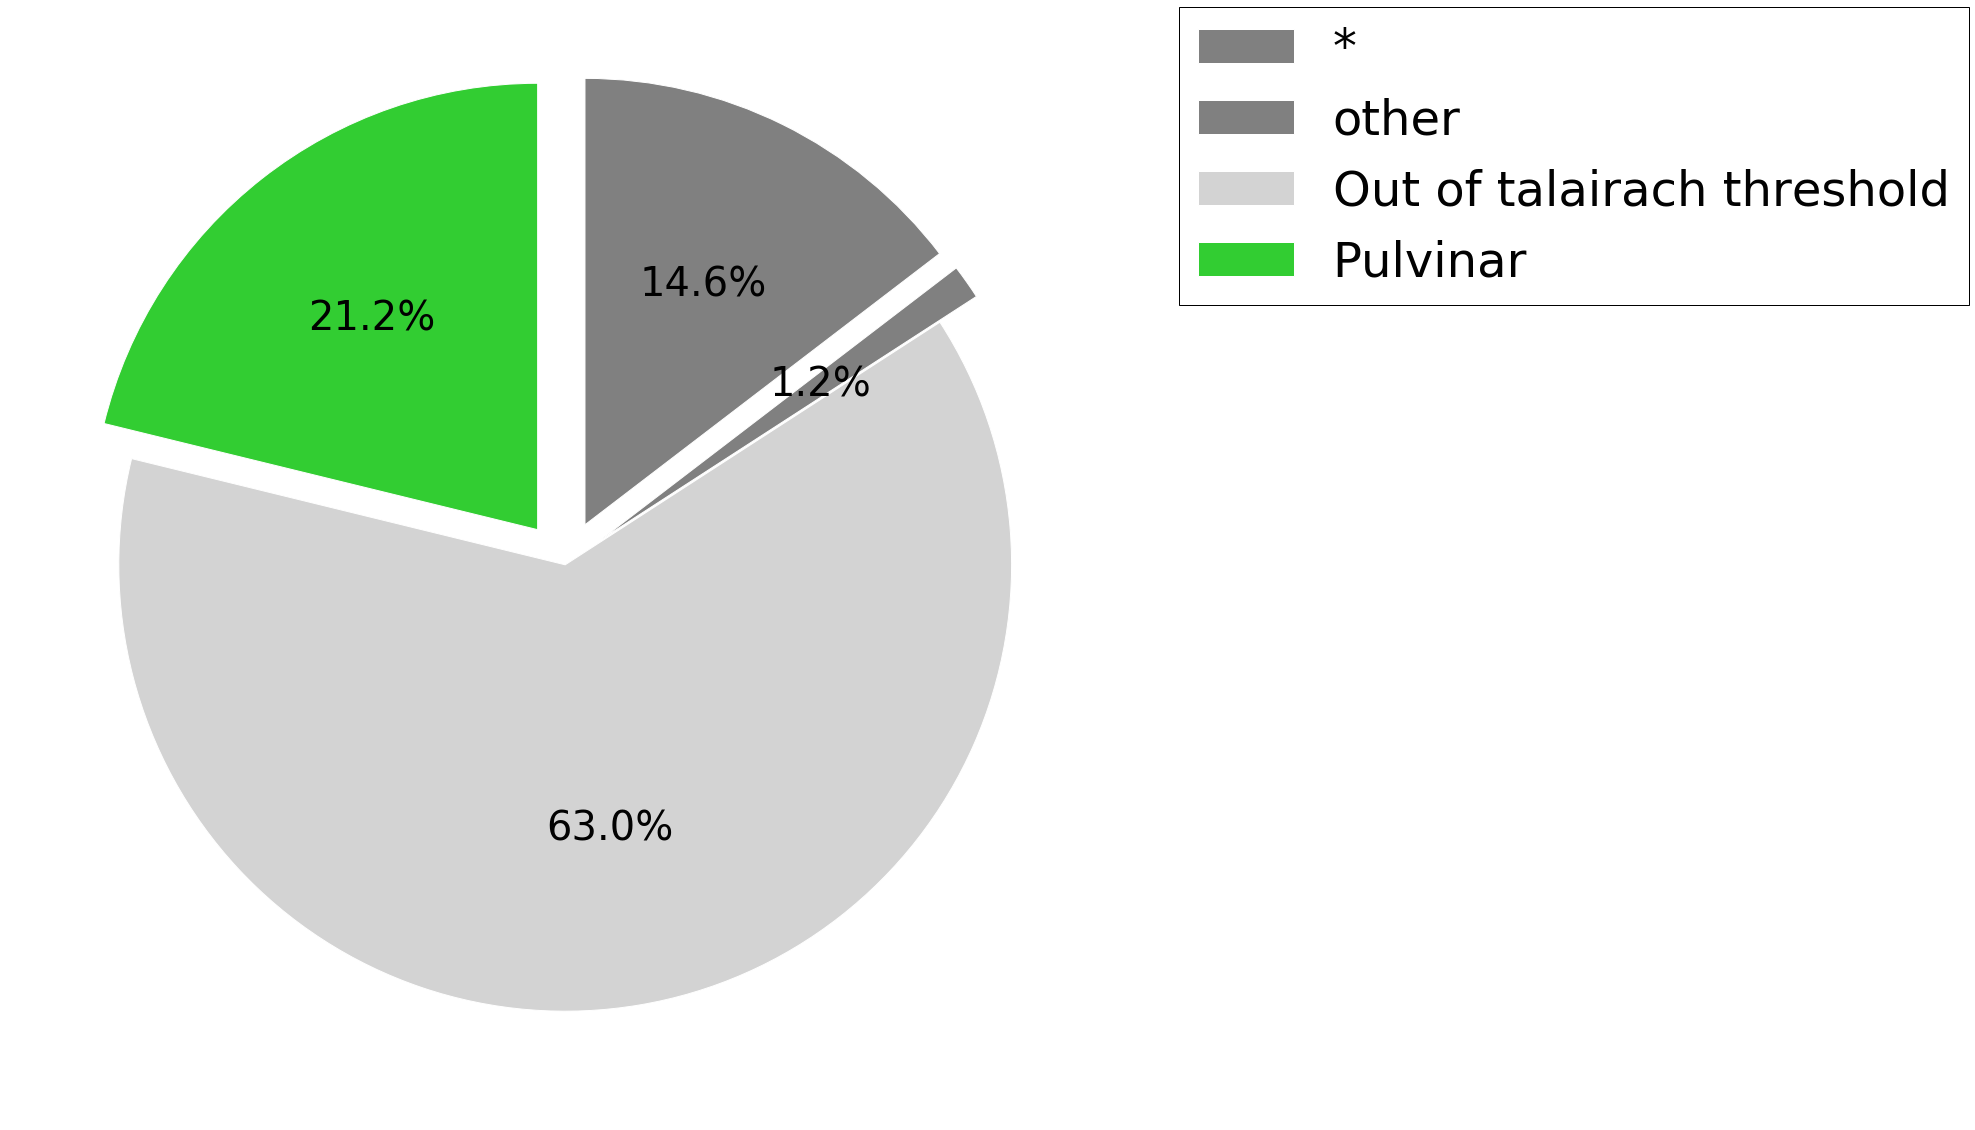

In [27]:
for ROI in ['OFC','LTC']:
    for side, ax_num in zip(['lh','rh'],[0,2]):
        fig2, axes = plt.subplots(ncols=1, figsize=(20,20), dpi=300)

        '''
        Threshold the map of accumulated thalamus connectivity by 98% percentile
        '''
        # change the allData to non-thresholded data later
        data = nothr_allData['{0}_{1}'.format(side, ROI)]
        print 'data shape', data.shape
        quartile_v = 95
        thr = np.percentile(data[data>0], quartile_v)

        data_mask = data > thr


        '''
        Get the spatial overlap between
        - the thresholded connectivity map of the thalamus
        - talairach thalamus data
        '''
        talairach_thalamus = talairach_data * mask
        overlap = data_mask * talairach_thalamus

        '''
        For each thalamic subnuclei,
        estimate the overlap percentage

        Overlap percentage 
        = 
        (overlap of the nuclei with the connectivity map/ whole connectivity area) * 100
        '''
        overlap_volumes_dict = {}
        overlap_connectivity_sum_dict={}
        for regionNum in np.unique(overlap[overlap!=0]):
            regionName = tal_thal_dict[regionNum]
            print regionName, regionNum
            overlap_nuclei_mask = overlap==regionNum
            overlap_nuclei_connectivity_sum = data[overlap_nuclei_mask]
            
            regionPercentage = np.sum(overlap_nuclei_mask) / np.sum(data_mask) * 100
            regionConnectivityPercentage = np.sum(overlap_nuclei_connectivity_sum) / np.sum(data[data_mask]) * 100
            
            if regionPercentage < 5:
                try:
                    overlap_volumes_dict['other'] = overlap_volumes_dict['other'] + regionPercentage
                except:
                    overlap_volumes_dict['other'] = regionPercentage
            else:
                overlap_volumes_dict[regionName] = regionPercentage
            
            if regionConnectivityPercentage < 5:
                try:
                    overlap_connectivity_sum_dict['other'] = overlap_connectivity_sum_dict['other'] + regionConnectivityPercentage
                except:
                    overlap_connectivity_sum_dict['other'] = regionConnectivityPercentage
            else:
                overlap_connectivity_sum_dict[regionName] = regionConnectivityPercentage

        print 'overlap_volumes_dict', overlap_volumes_dict
        print 'overlap_connectivity_sum_dict', overlap_connectivity_sum_dict

        '''
        Add non-overlapped area in the connectivity map as
        'Out of talairach threshold'
        '''
        overlap_volumes_dict['Out of talairach threshold'] = 100 - reduce(lambda x,y: x+y, overlap_volumes_dict.values())
        overlap_connectivity_sum_dict['Out of talairach threshold'] = 100 - reduce(lambda x,y: x+y, overlap_connectivity_sum_dict.values())


        pickle.dump(overlap_volumes_dict,
                   open('overlap_volume_dict_{ROI}_{side}.pickle'.format(ROI=ROI, side=side), 'wb'))

        pickle.dump(overlap_connectivity_sum_dict,
                   open('overlap_connectivity_sum_dict_{ROI}_{side}.pickle'.format(ROI=ROI, side=side), 'wb'))
        
        '''
        Make all items to explode out,
        except the 'Out of talairah threshold'
        '''
        pick = lambda x: 0 if x == 'Out of talairach threshold' else .1


        ''' pie chart '''
        matplotlib.rcParams['font.size'] = 40


        '''sort data'''
        sorted_overlap_volumes_list = dict(sorted(overlap_volumes_dict.items(), key=operator.itemgetter(1)))
#         sorted_overlap_volumes_list = dict(sorted(overlap_connectivity_sum_dict.items(), key=operator.itemgetter(1)))

        
        '''reorder data'''
        counterclock = lambda x: True if x == 'lh' else False
        
        pie_wedge_collection = axes.pie(sorted_overlap_volumes_list.values(), 
        # labels = [x.split('.')[-1] for x in sorted_overlap_volumes_list.keys()], 
        startangle=90,
        autopct='%1.1f%%',
        counterclock=counterclock(side),
        explode=([pick(x) for x in sorted_overlap_volumes_list.keys()]),
        colors = [colourmap_thalamus[x] for x in sorted_overlap_volumes_list.keys()],
        labeldistance=1.05,
        )
        '''white boundary'''
        for pie_wedge in pie_wedge_collection[0]:
            pie_wedge.set_edgecolor('white')
        #     axes.set_title('{ROI} {side}'.format(ROI=ROI, side=side), fontsize=25)


        plt.legend(pie_wedge_collection[0], [x.split('.')[-1] for x in sorted_overlap_volumes_list.keys()], 
                   bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)#loc="best")
        fig2.show()



> Connectivity weighted classification

data shape (182, 218, 182)
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar 622
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus 636
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Lateral Nucleus 643
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Anterior Nucleus 646
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus 686
overlap_volumes_dict {'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus': 18.572927597061909, 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Lateral Nucleus': 11.122770199370409, 'other': 1.7838405036726126, 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Anterior Nucleus': 14.060860440713535}
overlap_connectivity_sum_dict {'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus': 16.700023412704468, 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Lateral Nucleus': 11.107378453016281, 'other': 1.4886504621244967, 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Anterior 

/ccnc_bin/venv/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/ccnc_bin/venv/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


 {'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus': 14.949037372593432, 'other': 1.5855039637599093, 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus': 31.370328425821064}
overlap_connectivity_sum_dict {'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus': 15.897046029567719, 'other': 1.8672164529561996, 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus': 29.396367073059082}
data shape (182, 218, 182)
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar 622
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Medial Dorsal Nucleus 636
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Ventral Anterior Nucleus 646
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus 686
Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Midline Nucleus 790
overlap_volumes_dict {'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar': 30.745015739769148, 'other': 4.1972717733473246, 'Left Cerebrum.Sub-lobar.Thalamus.Gray Matter.Anterior Nucleus': 6

/ccnc_bin/venv/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/ccnc_bin/venv/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


 {'other': 1.245753114382786, 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar': 21.177802944507363}
overlap_connectivity_sum_dict {'other': 0.98425567848607898, 'Right Cerebrum.Sub-lobar.Thalamus.Gray Matter.Pulvinar': 21.581882238388062}


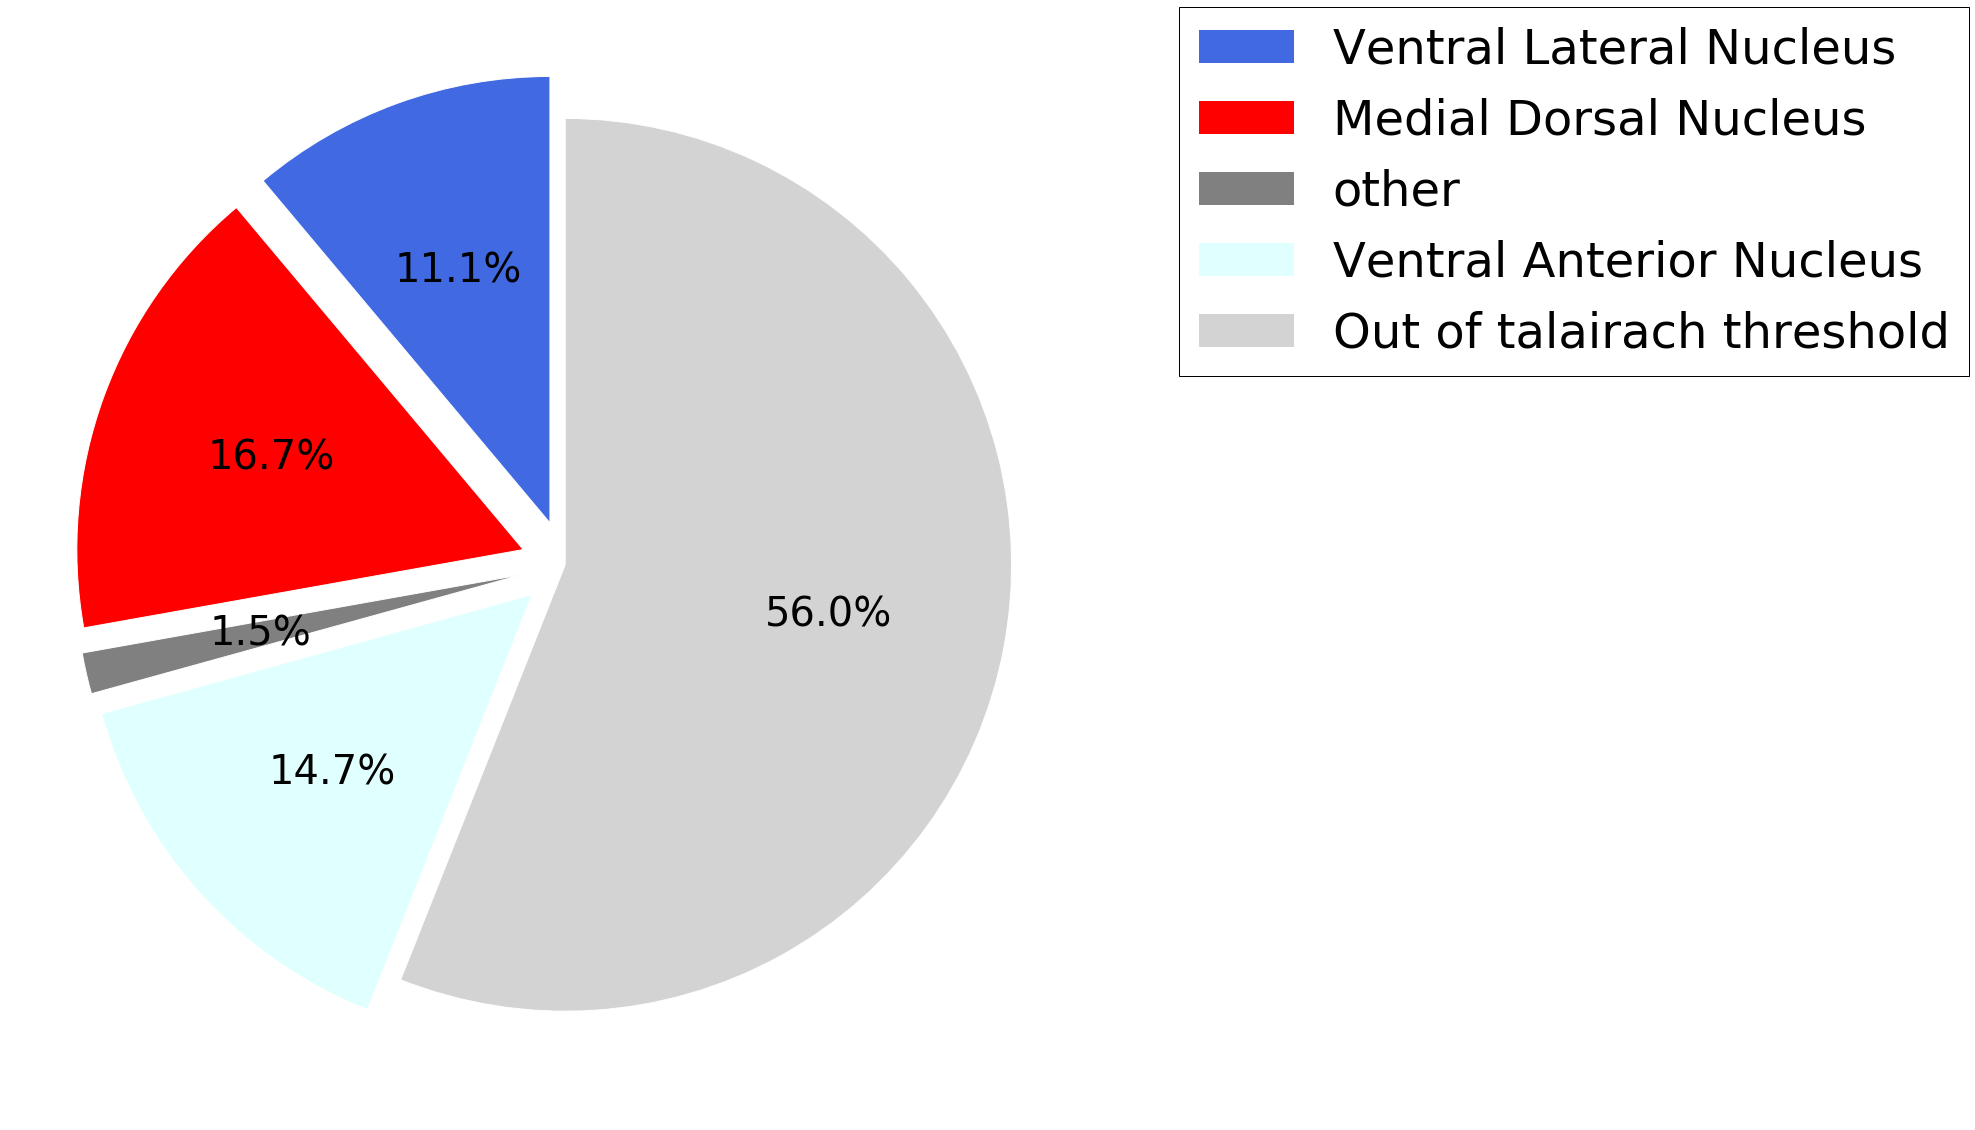

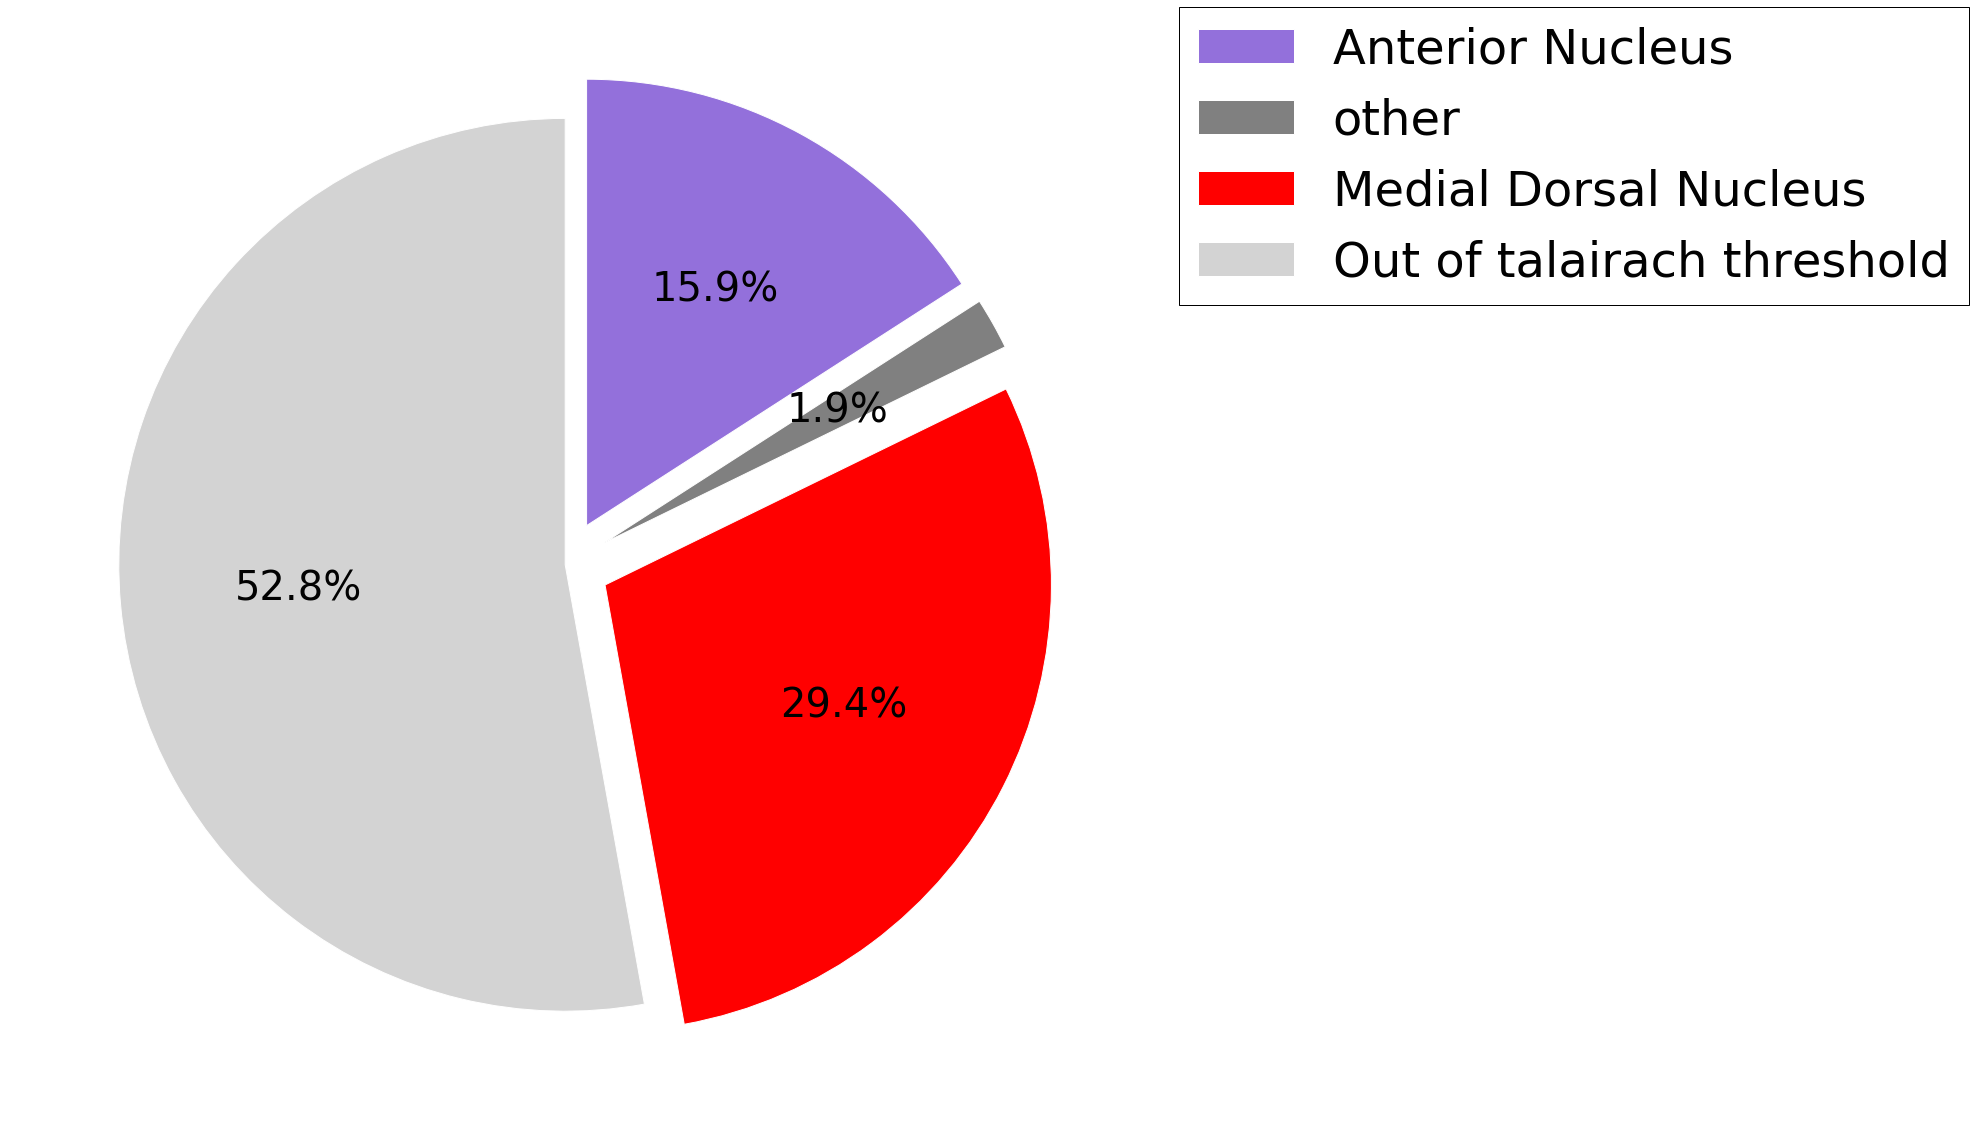

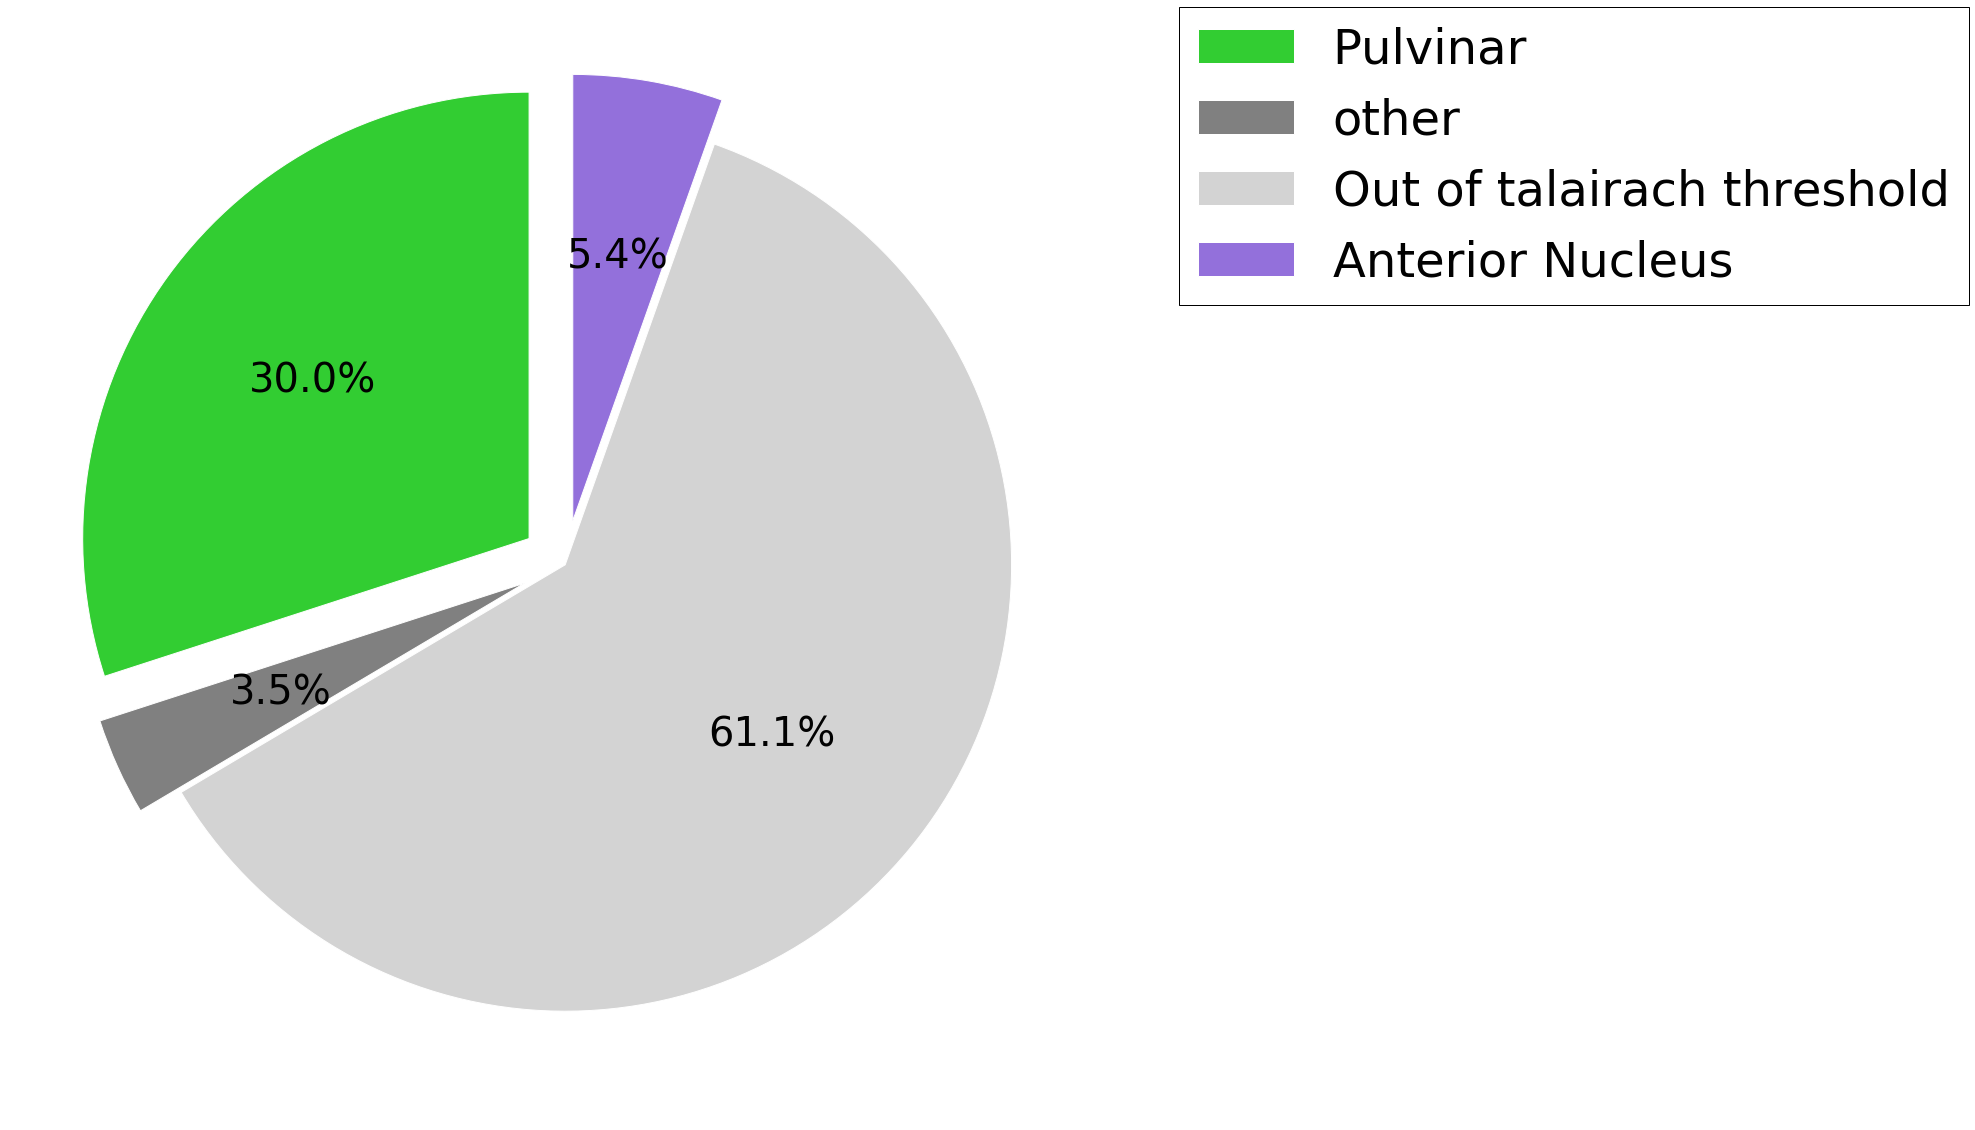

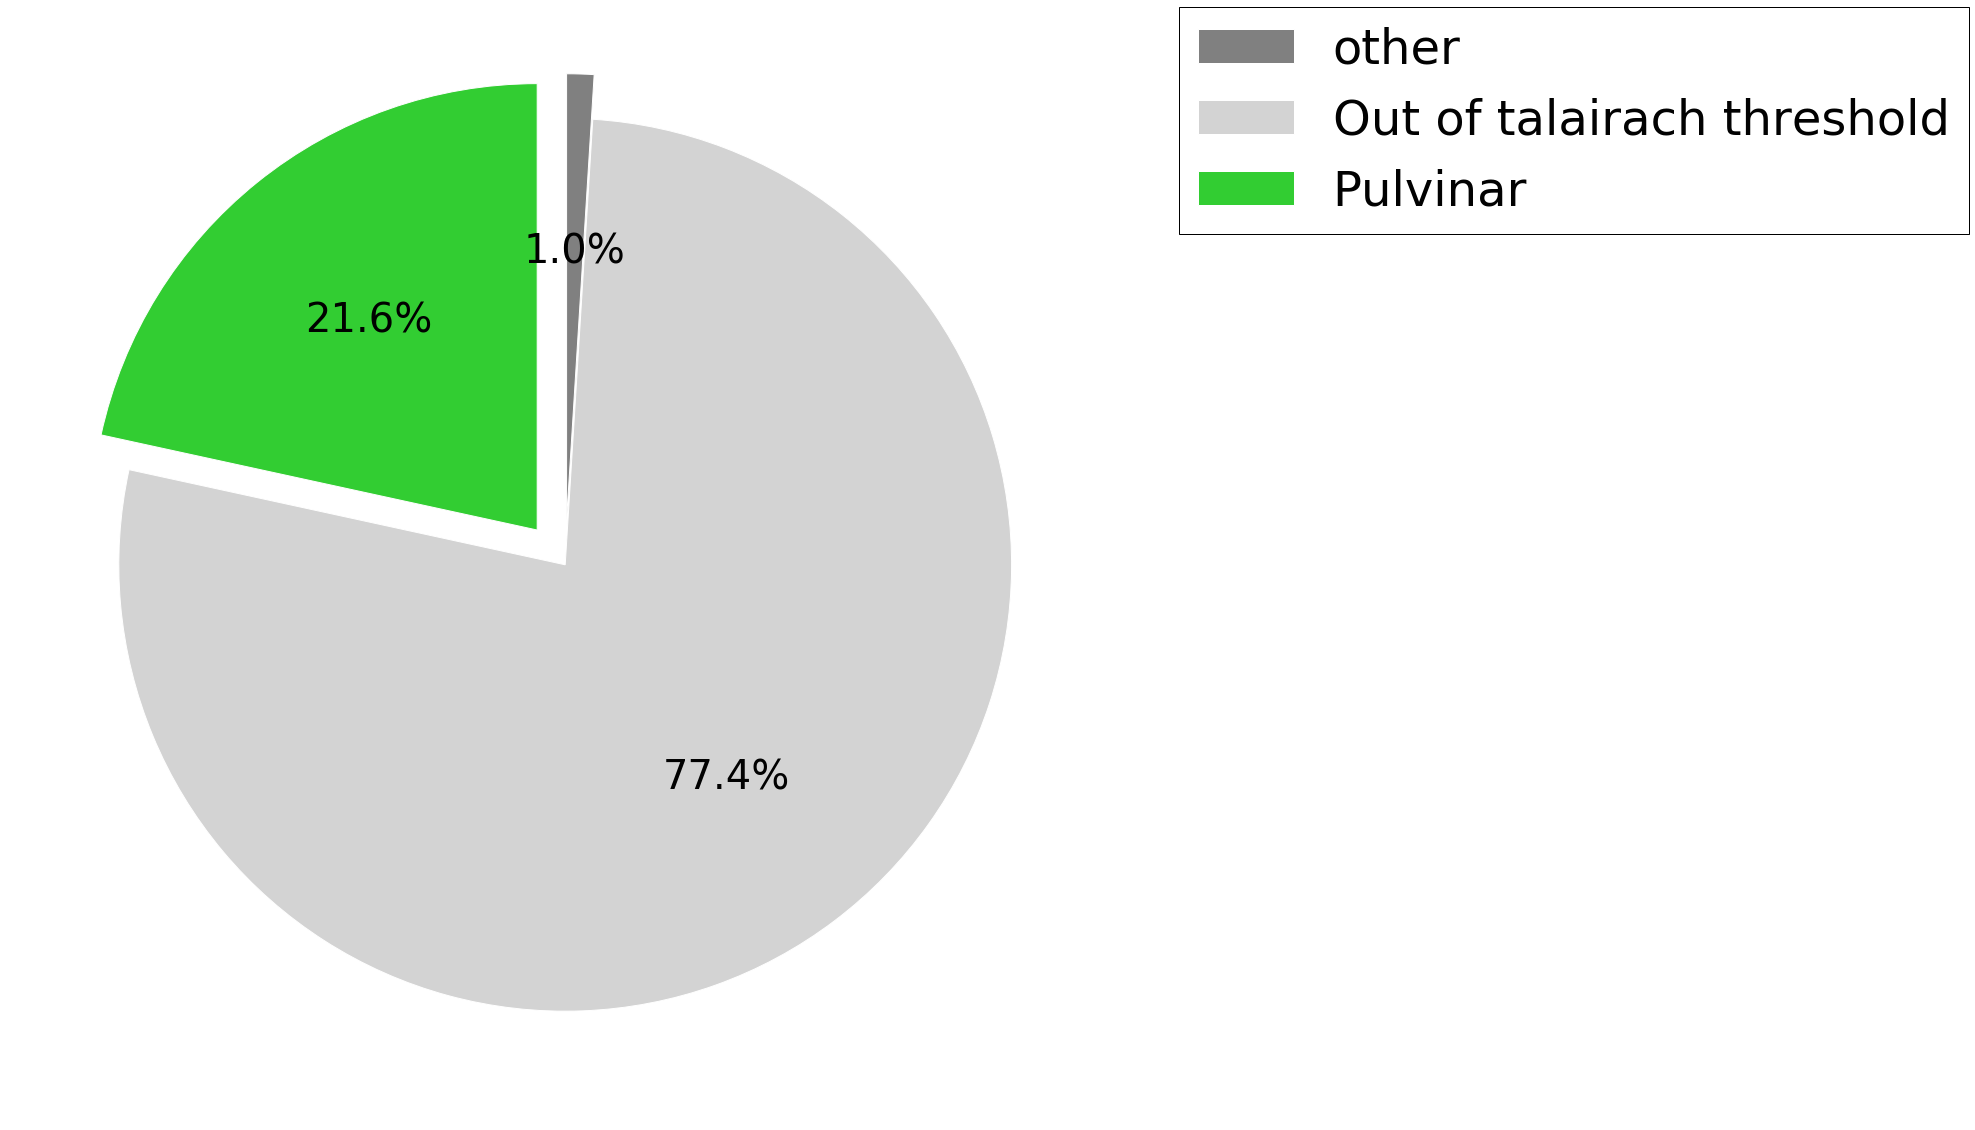

In [44]:
for ROI in ['OFC','LTC']:
    for side, ax_num in zip(['lh','rh'],[0,2]):
        fig2, axes = plt.subplots(ncols=1, figsize=(20,20), dpi=300)

        '''
        Threshold the map of accumulated thalamus connectivity by 98% percentile
        '''
        # change the allData to non-thresholded data later
        data = nothr_allData['{0}_{1}'.format(side, ROI)]
        print 'data shape', data.shape
        quartile_v = 95
        thr = np.percentile(data[data>0], quartile_v)

        data_mask = data > thr


        '''
        Get the spatial overlap between
        - the thresholded connectivity map of the thalamus
        - talairach thalamus data
        '''
        talairach_thalamus = talairach_data * mask
        overlap = data_mask * talairach_thalamus

        '''
        For each thalamic subnuclei,
        estimate the overlap percentage

        Overlap percentage 
        = 
        (overlap of the nuclei with the connectivity map/ whole connectivity area) * 100
        '''
        overlap_volumes_dict = {}
        overlap_connectivity_sum_dict={}
        for regionNum in np.unique(overlap[overlap!=0]):
            regionName = tal_thal_dict[regionNum]
            print regionName, regionNum
            overlap_nuclei_mask = overlap==regionNum
            overlap_nuclei_connectivity_sum = data[overlap_nuclei_mask]
            
            regionPercentage = np.sum(overlap_nuclei_mask) / np.sum(data_mask) * 100
            regionConnectivityPercentage = np.sum(overlap_nuclei_connectivity_sum) / np.sum(data[data_mask]) * 100
            
            if regionPercentage < 5:
                try:
                    overlap_volumes_dict['other'] = overlap_volumes_dict['other'] + regionPercentage
                except:
                    overlap_volumes_dict['other'] = regionPercentage
            else:
                overlap_volumes_dict[regionName] = regionPercentage
            
            if regionConnectivityPercentage < 5:
                try:
                    overlap_connectivity_sum_dict['other'] = overlap_connectivity_sum_dict['other'] + regionConnectivityPercentage
                except:
                    overlap_connectivity_sum_dict['other'] = regionConnectivityPercentage
            else:
                overlap_connectivity_sum_dict[regionName] = regionConnectivityPercentage

        print 'overlap_volumes_dict', overlap_volumes_dict
        print 'overlap_connectivity_sum_dict', overlap_connectivity_sum_dict

        '''
        Add non-overlapped area in the connectivity map as
        'Out of talairach threshold'
        '''
        overlap_volumes_dict['Out of talairach threshold'] = 100 - reduce(lambda x,y: x+y, overlap_volumes_dict.values())
        overlap_connectivity_sum_dict['Out of talairach threshold'] = 100 - reduce(lambda x,y: x+y, overlap_connectivity_sum_dict.values())


        pickle.dump(overlap_volumes_dict,
                   open('overlap_volume_dict_{ROI}_{side}.pickle'.format(ROI=ROI, side=side), 'wb'))

        pickle.dump(overlap_connectivity_sum_dict,
                   open('overlap_connectivity_sum_dict_{ROI}_{side}.pickle'.format(ROI=ROI, side=side), 'wb'))
        
        '''
        Make all items to explode out,
        except the 'Out of talairah threshold'
        '''
        pick = lambda x: 0 if x == 'Out of talairach threshold' else .1


        ''' pie chart '''
        matplotlib.rcParams['font.size'] = 40


        '''sort data'''
#         sorted_overlap_volumes_list = dict(sorted(overlap_volumes_dict.items(), key=operator.itemgetter(1)))
        sorted_overlap_volumes_list = dict(sorted(overlap_connectivity_sum_dict.items(), key=operator.itemgetter(1)))

        
        '''reorder data'''
        counterclock = lambda x: True if x == 'lh' else False
        
        pie_wedge_collection = axes.pie(sorted_overlap_volumes_list.values(), 
        # labels = [x.split('.')[-1] for x in sorted_overlap_volumes_list.keys()], 
        startangle=90,
        autopct='%1.1f%%',
        counterclock=counterclock(side),
        explode=([pick(x) for x in sorted_overlap_volumes_list.keys()]),
        colors = [colourmap_thalamus[x] for x in sorted_overlap_volumes_list.keys()],
        labeldistance=1.05,
        )
        '''white boundary'''
        for pie_wedge in pie_wedge_collection[0]:
            pie_wedge.set_edgecolor('white')
        #     axes.set_title('{ROI} {side}'.format(ROI=ROI, side=side), fontsize=25)


        plt.legend(pie_wedge_collection[0], [x.split('.')[-1] for x in sorted_overlap_volumes_list.keys()], 
                   bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)#loc="best")
        fig2.show()



In [26]:
'''Define the area to show'''
x1,x2 = (60,140)
y1,y2 = (40,140)

for ROI in ['OFC','LTC']:    
    
    slices = range(70,92)
    for sliceNum in slices:
        try:
            print sliceNum
            fig, ax = plt.subplots(figsize=(10,10), dpi=300)

            '''Make colormap from a dictionary {nuclei:color}'''
            my_cmap = copy(plt.cm.gray)
            my_cmap.set_under('green',alpha=0)

            '''Draw mni data'''
            ax.imshow(np.fliplr(np.flipud(mni_data[:,:,sliceNum].T))[x1:x2, y1:y2],
                    cmap=my_cmap)

            '''Draw each nuclei'''
            for nuclei_num in np.unique(talairach_thalamus[talairach_thalamus!=0]):

                try:
                    nuclei_name = tal_thal_dict[nuclei_num]
                    color = colourmap_thalamus[nuclei_name]
                except:
                    color= 'gray'

                my_cmap = copy(plt.cm.pink)
                my_cmap.set_under('green',alpha=0)
                my_cmap.set_over(color,alpha=1)
                my_cmap.set_bad('gold',alpha=.5)

                zero_except_nucleus = talairach_thalamus.copy()
                zero_except_nucleus[zero_except_nucleus!=nuclei_num] = 0

                ax.imshow(np.fliplr(np.flipud(zero_except_nucleus[:,:,sliceNum].T))[x1:x2, y1:y2],
                          cmap=my_cmap,
                          vmin=1,
                          vmax=2)

                ax.axis('off')

            for side in 'lh','rh':
                data = nothr_allData['{0}_{1}'.format(side, ROI)]
                quartile_v = 95
                thr = np.percentile(data[data>0], quartile_v)
                data_mask = data > thr

                '''Draw subject data'''
                my_cmap = copy(matplotlib.cm.get_cmap('YlOrRd')) # make a copy so we don't mess up system copy
                my_cmap.set_under('r', alpha=0) # make locations over vmax translucent red
                ax.imshow(np.fliplr(np.flipud(data[:,:,sliceNum].T))[x1:x2, y1:y2],
                            cmap=my_cmap,
                            alpha=.9,
                            vmin=thr)
                ax.axis('off')

    #         fig.show()
            fig.savefig('/Users/admin/Desktop/{ROI}_brain_overlap_ROIs_{sliceNum}.png'.format(ROI=ROI,sliceNum=sliceNum),
                       bbox_inches='tight', pad_inches=0, dpi=300)
            plt.close()
        except:
            print sliceNum, 'is not saved'
        


70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
84 is not saved
85
85 is not saved
86
86 is not saved
87
87 is not saved
88
88 is not saved
89
89 is not saved
90
90 is not saved
91
91 is not saved
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
88 is not saved
89
89 is not saved
90
90 is not saved
91
91 is not saved
Error in callback <function post_execute at 0x109fddb18> (for post_execute):


ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

In [31]:
from images2gif import writeGif
from PIL import Image

In [32]:
import glob

In [35]:
for ROI in ['OFC','LTC']:
    imgs = [Image.open(x) for x in glob.glob('/Users/admin/Desktop/{ROI}_brain_overlap*.png'.format(ROI=ROI))]
    order_reverse = copy(imgs)
    order_reverse.reverse()
    order_reverse = order_reverse[1:]
    imgs = imgs + order_reverse
#     c = imgs
#     imgs.reverse()
#     c += imgs[1:]
    writeGif('/Users/admin/Desktop/{ROI}_brain.gif'.format(ROI=ROI), imgs, duration=0.1, subRectangles=False)
#    a = [os.popen('rm {img}'.format(img=x)) for x in imgList]